# Testing Toponymy Audit Functionality

This notebook demonstrates how to use the new audit functionality in Toponymy to compare intermediate results (keyphrases, exemplars, subtopics) with final LLM-generated topic names.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# Import Toponymy and the new audit functions
from toponymy import Toponymy, ToponymyClusterer
from toponymy.audit import (
    create_audit_df,
    create_comparison_df,
    create_keyphrase_analysis_df,
    create_layer_summary_df,
    create_prompt_analysis_df,
    export_audit_excel,
    get_cluster_details
)

## 1. Load Sample Data

We'll use the 20-newsgroups dataset as shown in the README.

In [3]:
# Load the 20-newsgroups dataset with precomputed embeddings
print("Loading 20-newsgroups dataset...")
newsgroups_df = pd.read_parquet("hf://datasets/lmcinnes/20newsgroups_embedded/data/train-00000-of-00001.parquet")

# Extract text, vectors, and map
text = newsgroups_df["post"].str.strip().values
document_vectors = np.stack(newsgroups_df["embedding"].values)
document_map = np.stack(newsgroups_df["map"].values)

print(f"Loaded {len(text)} documents")
print(f"Document vectors shape: {document_vectors.shape}")
print(f"Document map shape: {document_map.shape}")

Loading 20-newsgroups dataset...
Loaded 18170 documents
Document vectors shape: (18170, 768)
Document map shape: (18170, 2)


## 2. Initialize Models

Set up the embedding model and LLM wrapper.

In [ ]:
# Initialize embedding model
print("Loading embedding model...")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize OpenAI LLM wrapper
import os

# IMPORTANT: Set your OpenAI API key
# Option 1: Environment variable (recommended)
openai_api_key = os.getenv("OPENAI_API_KEY")

# Option 2: Load from a file
# with open("openai_key.txt", "r") as f:
#     openai_api_key = f.read().strip()

if not openai_api_key:
    raise ValueError("Please set your OpenAI API key via OPENAI_API_KEY environment variable")

# Import and initialize OpenAI
from toponymy.llm_wrappers import OpenAI

# Create OpenAI wrapper
# Default model is gpt-4o-mini which is cost-effective for topic naming
llm = OpenAI(api_key=openai_api_key, model="gpt-4o-mini")

print("OpenAI model initialized!")
print(f"Using model: {llm.model}")
print("Ready to generate topic names using OpenAI API")

In [56]:
# Initialize embedding model
print("Loading embedding model...")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize OpenAI LLM wrapper
import os

# IMPORTANT: Replace with your actual OpenAI API key
# You can get one at: https://platform.openai.com/api-keys
openai_api_key = "sk-YOUR-API-KEY-HERE"  



# Alternative: Load from environment variable (recommended for security)
#openai_api_key = os.getenv("OPENAI_API_KEY")

# Alternative: Load from a file
# with open("openai_key.txt", "r") as f:
#     openai_api_key = f.read().strip()

# Import and initialize OpenAI
from toponymy.llm_wrappers import OpenAI

# Create OpenAI wrapper
# Default model is gpt-4o-mini which is cost-effective for topic naming
llm = OpenAI(api_key=openai_api_key, model="gpt-4o-mini")

print("OpenAI model initialized!")
print(f"Using model: {llm.model}")
print("Ready to generate topic names using OpenAI API")

Loading embedding model...
OpenAI model initialized!
Using model: gpt-4o-mini
Ready to generate topic names using OpenAI API


## 3. Create and Fit Toponymy Model

We'll use a smaller subset for faster testing.

In [57]:
# Use a subset for faster testing
subset_size = 300
text_subset = text[:subset_size]
vectors_subset = document_vectors[:subset_size]
map_subset = document_map[:subset_size]

print(f"Using subset of {subset_size} documents for testing")

Using subset of 300 documents for testing


In [58]:
# Estimate API costs before running
# GPT-4o-mini pricing (as of 2024): $0.15 per 1M input tokens, $0.60 per 1M output tokens

# Rough estimation
estimated_clusters = 20  # Approximate number of clusters across all layers
estimated_tokens_per_prompt = 1000  # Each prompt with keyphrases and exemplars
estimated_output_tokens = 20  # Topic names are short

total_input_tokens = estimated_clusters * estimated_tokens_per_prompt
total_output_tokens = estimated_clusters * estimated_output_tokens

# Calculate costs (prices in USD)
input_cost = (total_input_tokens / 1_000_000) * 0.15
output_cost = (total_output_tokens / 1_000_000) * 0.60
total_cost = input_cost + output_cost

print(f"Estimated OpenAI API costs for this test:")
print(f"  Input tokens: ~{total_input_tokens:,} (${input_cost:.4f})")
print(f"  Output tokens: ~{total_output_tokens:,} (${output_cost:.4f})")
print(f"  Total estimated cost: ${total_cost:.4f}")
print(f"\nNote: Actual costs may vary. Using subset_size={subset_size} documents")

Estimated OpenAI API costs for this test:
  Input tokens: ~20,000 ($0.0030)
  Output tokens: ~400 ($0.0002)
  Total estimated cost: $0.0032

Note: Actual costs may vary. Using subset_size=300 documents


In [59]:
# Initialize clusterer
# ToponymyClusterer doesn't have max_clusters parameter, adjust min_clusters and base_min_cluster_size instead
clusterer = ToponymyClusterer(min_clusters=3, base_min_cluster_size=10)

# Initialize Toponymy
topic_model = Toponymy(
    llm_wrapper=llm,
    text_embedding_model=embedding_model,
    clusterer=clusterer,
    object_description="newsgroup posts",
    corpus_description="20-newsgroups dataset",
    exemplar_delimiters=["<EXAMPLE_POST>\n", "\n</EXAMPLE_POST>\n\n"],
)

print("Fitting Toponymy model...")
print("This will make API calls to OpenAI - costs will apply!")
topic_model.fit(text_subset, vectors_subset, map_subset)
print("Model fitted!")

Fitting Toponymy model...
This will make API calls to OpenAI - costs will apply!


Selecting facility_location exemplars:   0%|          | 0/10 [00:00<?, ?cluster/s]

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Building topic names by layer:   0%|          | 0/2 [00:00<?, ?layer/s]

Generating informative keyphrases:   0%|          | 0/10 [00:00<?, ?cluster/s]

Generating prompts for layer 0:   0%|          | 0/10 [00:00<?, ?topic/s]

Generating topic names for layer 0:   0%|          | 0/10 [00:00<?, ?topic/s]

Selecting central exemplars:   0%|          | 0/4 [00:00<?, ?cluster/s]

Generating informative keyphrases:   0%|          | 0/4 [00:00<?, ?cluster/s]

Selecting central subtopics:   0%|          | 0/4 [00:00<?, ?cluster/s]

Generating prompts for layer 1:   0%|          | 0/4 [00:00<?, ?topic/s]

Generating topic names for layer 1:   0%|          | 0/4 [00:00<?, ?topic/s]

Model fitted!


In [60]:
# Show basic model information
print(f"Number of layers: {len(topic_model.cluster_layers_)}")
for i, layer in enumerate(topic_model.cluster_layers_):
    n_clusters = len(np.unique(layer.cluster_labels)) - 1  # Exclude -1
    print(f"Layer {i}: {n_clusters} clusters")

Number of layers: 2
Layer 0: 10 clusters
Layer 1: 4 clusters


## 4. Test Audit Functions

Now let's test the various audit functions to see intermediate vs final results.

### 4.1 Layer Summary

In [61]:
# Get overall layer summary
layer_summary = create_layer_summary_df(topic_model)
print("Layer Summary:")
layer_summary

Layer Summary:


,layer,num_clusters,avg_cluster_size,min_cluster_size,max_cluster_size,unique_topic_names,duplicate_topic_names,has_subtopics
0,0,10,17.0,10,30,10,0,True
1,1,4,60.0,27,107,4,0,True


### 4.2 Comparison View - Intermediate vs Final Results

In [68]:
# Show comparison for layer 0 (most detailed layer)
comparison_df = create_comparison_df(topic_model, layer_index=1)
print("\nComparison of Intermediate vs LLM Results (Layer 0, first 10 clusters):")
comparison_df.head(10)


Comparison of Intermediate vs LLM Results (Layer 0, first 10 clusters):


,Cluster ID,Document Count,Extracted Keyphrases (Top 5),Exemplar Count,Child Subtopics,Final LLM Topic Name
0,0,27,"games, player, season, mike, bob",8,"NHL Hockey Discussions: Teams, Players, and Ga...",Sports Analysis
1,1,76,"god, people, said, war, death",8,Government Accountability and Moral Justificat...,Religion and Morality
2,2,107,"windows, video card, drivers, local bus, edu",8,Vintage Computer Hardware and Performance Benc...,Computer Hardware
3,3,30,"car, oil, river water, bike, energy conservation",8,"Automotive Discussions on Maintenance, Perform...","Automotive Discussions on Maintenance, Perform..."


In [63]:
# Show comparison for a higher layer (more general topics)
if len(topic_model.cluster_layers_) > 2:
    comparison_df_layer2 = create_comparison_df(topic_model, layer_index=2)
    print("\nComparison for Layer 2 (broader topics):")
    display(comparison_df_layer2.head(10))

### 4.3 Detailed Audit DataFrame

In [64]:
# Get detailed audit for layer 0
audit_df = create_audit_df(topic_model, layer_index=0)

# Show selected columns for first few clusters
print("\nDetailed Audit Information:")
audit_df[['cluster_id', 'num_documents', 'num_keyphrases', 'num_exemplars', 
          'top_5_keyphrases', 'llm_topic_name']].head()


Detailed Audit Information:


,cluster_id,num_documents,num_keyphrases,num_exemplars,top_5_keyphrases,llm_topic_name
0,0,17,16,8,"games, season, player, bruins, dave","NHL Hockey Discussions: Teams, Players, and Ga..."
1,1,10,16,8,"average hitter, pagnozzi, ball, xxx, prince",Analysis of Rookie Baseball Players and Perfor...
2,2,13,16,8,"space station, manned, kc, lunar, o'connor",Manned Lunar Missions and Space Exploration Te...
3,3,12,16,8,"armenian, azeri, muslim villages, baku, mr",Armenian-Azeri Conflict and Humanitarian Crisi...
4,4,17,16,8,"batf, morality, koresh, criminals, paranoia",Government Accountability and Moral Justificat...


In [65]:
# Look at a specific cluster in detail
cluster_to_inspect = 0
cluster_audit = audit_df[audit_df['cluster_id'] == cluster_to_inspect].iloc[0]

print(f"\nDetailed view of Cluster {cluster_to_inspect}:")
print(f"Number of documents: {cluster_audit['num_documents']}")
print(f"\nKeyphrases extracted: {cluster_audit['num_keyphrases']}")
print(f"Top 5 keyphrases: {cluster_audit['top_5_keyphrases']}")
print(f"\nNumber of exemplars: {cluster_audit['num_exemplars']}")
print(f"\nFirst exemplar preview:")
print(cluster_audit['first_exemplar'])
print(f"\nFinal LLM topic name: '{cluster_audit['llm_topic_name']}'")


Detailed view of Cluster 0:
Number of documents: 17

Keyphrases extracted: 16
Top 5 keyphrases: games, season, player, bruins, dave

Number of exemplars: 8

First exemplar preview:
Listen guys you can talk about this the whole playoffs.  I'm here in a
small town in southern Illinois at school.  I'm from Canada and I know
that cbc and tsn have games on every night,  all you have to do is go to
a bar with a satellite.  I have watched both games between Mon Que and
toronto and de...

Final LLM topic name: 'NHL Hockey Discussions: Teams, Players, and Game Analysis'


### 4.4 Keyphrase Analysis

In [69]:
# Analyze how keyphrases relate to topic names
keyphrase_df = create_keyphrase_analysis_df(topic_model, layer_index=0)

# Show some examples
print("\nKeyphrase to Topic Name Mapping (first 20):")
display(keyphrase_df.head(20))

# Summary statistics
keyphrase_usage = keyphrase_df['keyphrase_in_topic'].value_counts()
print(f"\nKeyphrase usage in topic names:")
print(f"Keyphrases appearing in topic names: {keyphrase_usage.get(True, 0)}")
print(f"Keyphrases NOT in topic names: {keyphrase_usage.get(False, 0)}")
print(f"Percentage of keyphrases used: {keyphrase_usage.get(True, 0) / len(keyphrase_df) * 100:.1f}%")


Keyphrase to Topic Name Mapping (first 20):


,cluster_id,keyphrase,llm_topic_name,keyphrase_in_topic
0,0,games,"NHL Hockey Discussions: Teams, Players, and Ga...",False
1,0,season,"NHL Hockey Discussions: Teams, Players, and Ga...",False
2,0,player,"NHL Hockey Discussions: Teams, Players, and Ga...",True
3,0,bruins,"NHL Hockey Discussions: Teams, Players, and Ga...",False
4,0,dave,"NHL Hockey Discussions: Teams, Players, and Ga...",False
5,0,mtl,"NHL Hockey Discussions: Teams, Players, and Ga...",False
6,0,cbc,"NHL Hockey Discussions: Teams, Players, and Ga...",False
7,0,dale,"NHL Hockey Discussions: Teams, Players, and Ga...",False
8,0,tsn,"NHL Hockey Discussions: Teams, Players, and Ga...",False
9,0,denis savard,"NHL Hockey Discussions: Teams, Players, and Ga...",False



Keyphrase usage in topic names:
Keyphrases appearing in topic names: 11
Keyphrases NOT in topic names: 89
Percentage of keyphrases used: 11.0%


### 4.5 Prompt Analysis

In [70]:
# Analyze prompts sent to LLM
prompt_df = create_prompt_analysis_df(topic_model)

print("\nPrompt Analysis:")
display(prompt_df.head(10))

# Summary statistics
print("\nPrompt Statistics:")
print(f"Average prompt length: {prompt_df['prompt_length'].mean():.0f} characters")
print(f"Min prompt length: {prompt_df['prompt_length'].min()}")
print(f"Max prompt length: {prompt_df['prompt_length'].max()}")
print(f"\nAverage topic name length: {prompt_df['topic_name_length'].mean():.1f} characters")


Prompt Analysis:


,layer,cluster_id,prompt_length,num_exemplars_in_prompt,num_keyphrases_in_prompt,topic_name,topic_name_length
0,0,0,5127,16,10,"NHL Hockey Discussions: Teams, Players, and Ga...",57
1,0,1,4650,16,10,Analysis of Rookie Baseball Players and Perfor...,59
2,0,2,8777,16,9,Manned Lunar Missions and Space Exploration Te...,56
3,0,3,12155,16,10,Armenian-Azeri Conflict and Humanitarian Crisi...,69
4,0,4,6829,16,10,Government Accountability and Moral Justificat...,76
5,0,5,21011,16,10,"Christian Theology: Law, Grace, and the Nature...",53
6,0,6,5464,16,10,"Automotive Discussions on Maintenance, Perform...",76
7,0,7,4561,16,10,Vintage Computer Hardware and Performance Benc...,66
8,0,8,7688,16,10,X11R5 and Motif Programming Issues and Solutions,48
9,0,9,6782,16,10,Discussion on Video Card Drivers and Compatibi...,57



Prompt Statistics:
Average prompt length: 7974 characters
Min prompt length: 86
Max prompt length: 21011

Average topic name length: 53.3 characters


### 4.6 Get Full Details for a Specific Cluster

In [71]:
# Get complete details for a specific cluster including the actual prompt
cluster_details = get_cluster_details(topic_model, layer_index=0, cluster_id=0)

print("\nComplete Cluster Details:")
print(f"Layer: {cluster_details['layer']}")
print(f"Cluster ID: {cluster_details['cluster_id']}")
print(f"Number of documents: {cluster_details['num_documents']}")
print(f"Topic name: {cluster_details['topic_name']}")

print(f"\nKeyphrases (top 10): {cluster_details['keyphrases'][:10]}")
print(f"\nNumber of exemplars: {len(cluster_details['exemplars'])}")

if 'prompt' in cluster_details:
    print(f"\nPrompt sent to LLM (first 1000 chars):")
    print(str(cluster_details['prompt'])[:1000] + "...")


Complete Cluster Details:
Layer: 0
Cluster ID: 0
Number of documents: 17
Topic name: NHL Hockey Discussions: Teams, Players, and Game Analysis

Keyphrases (top 10): ['games', 'season', 'player', 'bruins', 'dave', 'mtl', 'cbc', 'dale', 'tsn', 'denis savard']

Number of exemplars: 8

Prompt sent to LLM (first 1000 chars):
{'system': '\nYou are an expert at classifying newsgroup posts from 20-newsgroups dataset into topics.\nYour task is to analyze information about a group of newsgroup posts and assign a domain expert level (8 to 15 word) name to this group.\nThe response must be in JSON formatted as {"topic_name":<NAME>, "topic_specificity":<SCORE>}\nwhere NAME is the topic name you generate and SCORE is a float value between 0.0 and 1.0,\nrepresenting how specific and well-defined the topic name is given the input information.\nA score of 1.0 means a perfectly descriptive and specific name, while 0.0 would be a completely generic or unrelated name.\n\n\nEnsure your entire response is 

### 4.7 Export to Excel

In [73]:
# # Export all audit data to Excel file
# export_audit_excel(topic_model, "toponymy_audit_report.xlsx")
# print("\nExcel file created with multiple sheets containing all audit data!")

## 5. Visualize Audit Results

Let's create some visualizations to better understand the relationship between intermediate and final results.

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

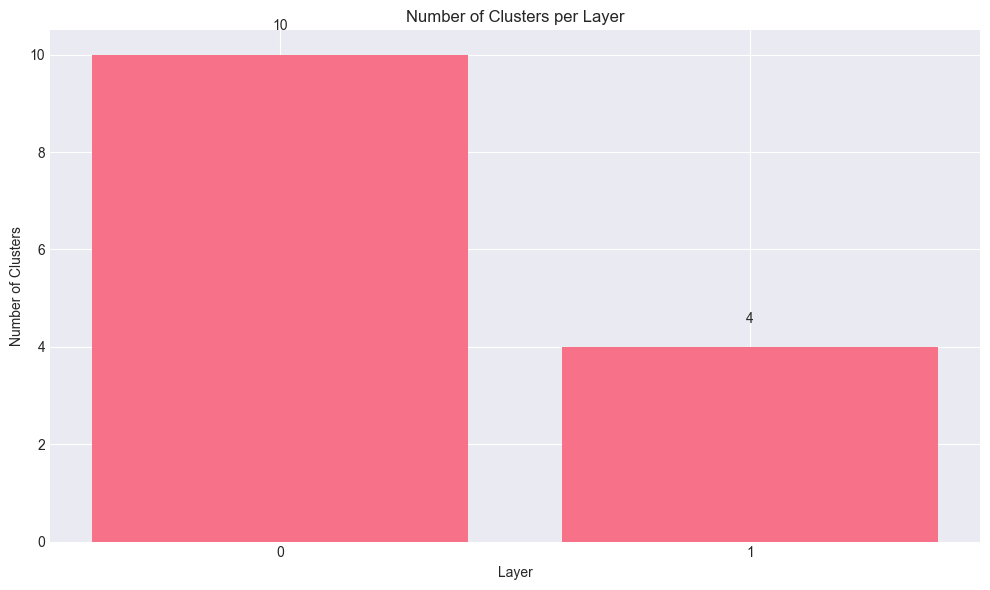

In [78]:
# Visualize cluster sizes across layers
fig, ax = plt.subplots(figsize=(10, 6))

layer_summary = create_layer_summary_df(topic_model)
x = layer_summary['layer']
y = layer_summary['num_clusters']

ax.bar(x, y)
ax.set_xlabel('Layer')
ax.set_ylabel('Number of Clusters')
ax.set_title('Number of Clusters per Layer')
ax.set_xticks(x)

# Add value labels on bars
for i, v in enumerate(y):
    ax.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

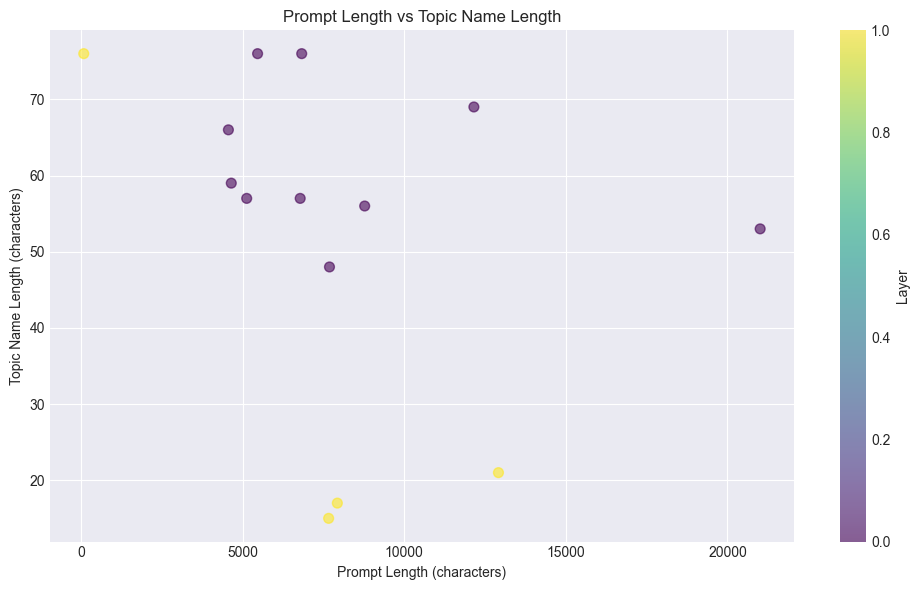

In [79]:
# Analyze relationship between prompt length and topic name length
prompt_df = create_prompt_analysis_df(topic_model)

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(prompt_df['prompt_length'], 
                    prompt_df['topic_name_length'],
                    c=prompt_df['layer'],
                    cmap='viridis',
                    alpha=0.6,
                    s=50)

ax.set_xlabel('Prompt Length (characters)')
ax.set_ylabel('Topic Name Length (characters)')
ax.set_title('Prompt Length vs Topic Name Length')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Layer')

plt.tight_layout()
plt.show()

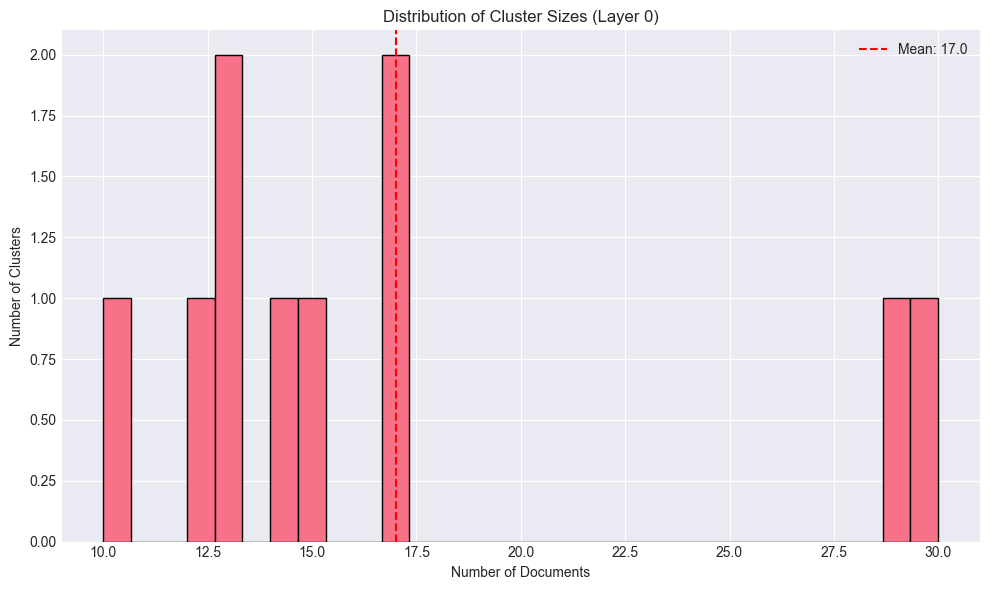

In [80]:
# Show distribution of cluster sizes
audit_df = create_audit_df(topic_model, layer_index=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(audit_df['num_documents'], bins=30, edgecolor='black')
ax.set_xlabel('Number of Documents')
ax.set_ylabel('Number of Clusters')
ax.set_title('Distribution of Cluster Sizes (Layer 0)')
ax.axvline(audit_df['num_documents'].mean(), color='red', linestyle='--', 
           label=f'Mean: {audit_df["num_documents"].mean():.1f}')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Example Use Cases for Auditing

Here are some practical examples of how to use the audit functionality:

### 6.1 Find clusters where keyphrases don't match topic names

In [81]:
# Find potential mismatches
audit_df = create_audit_df(topic_model, layer_index=0)

# Check if any top keyphrases appear in the topic name
mismatches = []
for _, row in audit_df.iterrows():
    top_keyphrases = row['top_5_keyphrases'].lower().split(', ')
    topic_name = row['llm_topic_name'].lower()
    
    # Check if any keyphrase appears in topic name
    match_found = any(kp in topic_name for kp in top_keyphrases if kp)
    
    if not match_found and row['num_documents'] > 10:  # Only consider clusters with >10 docs
        mismatches.append({
            'cluster_id': row['cluster_id'],
            'keyphrases': row['top_5_keyphrases'],
            'topic_name': row['llm_topic_name'],
            'num_docs': row['num_documents']
        })

print(f"Found {len(mismatches)} clusters where top keyphrases don't appear in topic name:")
for m in mismatches[:5]:  # Show first 5
    print(f"\nCluster {m['cluster_id']} ({m['num_docs']} docs):")
    print(f"  Keyphrases: {m['keyphrases']}")
    print(f"  Topic name: {m['topic_name']}")

Found 3 clusters where top keyphrases don't appear in topic name:

Cluster 4 (17 docs):
  Keyphrases: batf, morality, koresh, criminals, paranoia
  Topic name: Government Accountability and Moral Justification in Law Enforcement Actions

Cluster 6 (30 docs):
  Keyphrases: car, oil, river water, bike, temperature
  Topic name: Automotive Discussions on Maintenance, Performance, and Environmental Impact

Cluster 7 (13 docs):
  Keyphrases: simms and vram, motherboard, machines, heard of cache, pc
  Topic name: Vintage Computer Hardware and Performance Benchmarking Discussions


### 6.2 Find duplicate topic names

In [82]:
# Find duplicate topic names within each layer
for layer_idx in range(len(topic_model.cluster_layers_)):
    layer = topic_model.cluster_layers_[layer_idx]
    topic_counts = pd.Series(layer.topic_names).value_counts()
    duplicates = topic_counts[topic_counts > 1]
    
    if len(duplicates) > 0:
        print(f"\nLayer {layer_idx} - Duplicate topic names:")
        for topic, count in duplicates.items():
            print(f"  '{topic}' appears {count} times")

### 6.3 Analyze topic quality by cluster size

In [83]:
# Compare small vs large clusters
audit_df = create_audit_df(topic_model, layer_index=0)

# Define small and large clusters
small_clusters = audit_df[audit_df['num_documents'] < 20]
large_clusters = audit_df[audit_df['num_documents'] > 100]

print("Small clusters (<20 docs):")
print(f"  Count: {len(small_clusters)}")
print(f"  Avg keyphrases: {small_clusters['num_keyphrases'].mean():.1f}")
print(f"  Avg topic name length: {small_clusters['llm_topic_name'].str.len().mean():.1f}")

print("\nLarge clusters (>100 docs):")
print(f"  Count: {len(large_clusters)}")
print(f"  Avg keyphrases: {large_clusters['num_keyphrases'].mean():.1f}")
print(f"  Avg topic name length: {large_clusters['llm_topic_name'].str.len().mean():.1f}")

print("\nExample small cluster topics:")
for _, row in small_clusters.head(3).iterrows():
    print(f"  - {row['llm_topic_name']} ({row['num_documents']} docs)")

print("\nExample large cluster topics:")
for _, row in large_clusters.head(3).iterrows():
    print(f"  - {row['llm_topic_name']} ({row['num_documents']} docs)")

Small clusters (<20 docs):
  Count: 8
  Avg keyphrases: 16.0
  Avg topic name length: 61.0

Large clusters (>100 docs):
  Count: 0
  Avg keyphrases: nan
  Avg topic name length: nan

Example small cluster topics:
  - NHL Hockey Discussions: Teams, Players, and Game Analysis (17 docs)
  - Analysis of Rookie Baseball Players and Performance Metrics (10 docs)
  - Manned Lunar Missions and Space Exploration Technologies (13 docs)

Example large cluster topics:


## Summary

The audit functionality provides several ways to inspect and validate Toponymy results:

1. **`create_audit_df()`** - Get comprehensive audit data as a DataFrame
2. **`create_comparison_df()`** - Simple side-by-side comparison of intermediate vs final results
3. **`create_keyphrase_analysis_df()`** - Analyze how keyphrases relate to topic names
4. **`create_layer_summary_df()`** - High-level statistics for each layer
5. **`create_prompt_analysis_df()`** - Analyze prompt characteristics
6. **`get_cluster_details()`** - Get all details for a specific cluster
7. **`export_audit_excel()`** - Export everything to Excel for further analysis

This allows you to:
- Verify that topic names accurately reflect the extracted keyphrases and exemplars
- Identify potential issues or mismatches
- Understand how the LLM is interpreting the intermediate data
- Debug and improve your topic modeling pipeline

In [87]:
comparison_df = create_comparison_df(topic_model, layer_index=0)
print("\nComparison of Intermediate vs LLM Results (Layer 0, first 10 clusters):")
comparison_df.head(10)


Comparison of Intermediate vs LLM Results (Layer 0, first 10 clusters):


,Cluster ID,Document Count,Extracted Keyphrases (Top 5),Exemplar Count,Child Subtopics,Final LLM Topic Name
0,0,17,"games, season, player, bruins, dave",8,,"NHL Hockey Discussions: Teams, Players, and Ga..."
1,1,10,"average hitter, pagnozzi, ball, xxx, prince",8,,Analysis of Rookie Baseball Players and Perfor...
2,2,13,"space station, manned, kc, lunar, o'connor",8,,Manned Lunar Missions and Space Exploration Te...
3,3,12,"armenian, azeri, muslim villages, baku, mr",8,,Armenian-Azeri Conflict and Humanitarian Crisi...
4,4,17,"batf, morality, koresh, criminals, paranoia",8,,Government Accountability and Moral Justificat...
5,5,29,"god, sin, bible, holy spirit, faith",8,,"Christian Theology: Law, Grace, and the Nature..."
6,6,30,"car, oil, river water, bike, temperature",8,,"Automotive Discussions on Maintenance, Perform..."
7,7,13,"simms and vram, motherboard, machines, heard o...",8,,Vintage Computer Hardware and Performance Benc...
8,8,14,"x11r5 and motif, window, individual widget, 00...",8,,X11R5 and Motif Programming Issues and Solutions
9,9,15,"video card, new drivers, ami pro, run windows,...",8,,Discussion on Video Card Drivers and Compatibi...
